In [2]:
import pandas as pd
from pathlib import Path

# === CONFIG ===
PARQUET_PATH = Path("../data/twse_2025.parquet")
OUTPUT_DIR = Path("../data/alphalens_ready")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Load
df = pd.read_parquet(PARQUET_PATH)

# Expecting columns: ['market','stock_id','date','open','high','low','close','volume']
required = {"stock_id","date","open","close"}
missing = required - set(df.columns)
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# 2) Standardize
df = df[["date", "stock_id", "open", "close"]].rename(
    columns={"stock_id":"asset"}
)
df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None).dt.date
df["asset"] = df["asset"].astype(str).str.strip()

# De-duplicate if needed
df = df.drop_duplicates(subset=["date","asset"], keep="last")

# 3) Wide tables
open_w  = df.pivot(index="date", columns="asset", values="open").sort_index().astype(float)
close_w = df.pivot(index="date", columns="asset", values="close").sort_index().astype(float)

# 4) Prices for Alphalens (close)
prices = close_w.copy()

# 5) Factor: (t-1 close - t-1 open), shifted forward to date t
factor_wide = (close_w - open_w).shift(1)

# If you prefer percentage form, use:
# factor_wide = ((close_w - open_w) / open_w).shift(1)

# 6) MultiIndex factor Series
factor = factor_wide.stack().rename("factor").dropna()

# 7) Save
prices.to_parquet(OUTPUT_DIR / "prices.parquet")
factor.to_frame().to_parquet(OUTPUT_DIR / "factor_co_prevday.parquet")

print("Done.")
print("prices shape:", prices.shape)
print("factor length:", len(factor))
print("factor sample:\n", factor.head())


Done.
prices shape: (165, 994)
factor length: 162305
factor sample:
 date        asset
2025-01-03  1101     0.05
            1102     0.00
            1103     0.10
            1104    -0.20
            1108    -0.05
Name: factor, dtype: float64


In [9]:
factor

date        asset
2025-01-03  1101     0.05
            1102     0.00
            1103     0.10
            1104    -0.20
            1108    -0.05
                     ... 
2025-09-05  9944     0.10
            9945     1.70
            9946     1.75
            9955    -0.75
            9958    -1.00
Name: factor, Length: 162305, dtype: float64

In [5]:
import pandas as pd

# 保證 prices 用 DatetimeIndex（不是 date）
prices.index = pd.to_datetime(prices.index).tz_localize(None)

# 保證 factor 的第一層也是 DatetimeIndex
factor.index = pd.MultiIndex.from_arrays([
    pd.to_datetime(factor.index.get_level_values(0)).tz_localize(None),
    factor.index.get_level_values(1)
], names=["date", "asset"])


In [10]:
import pandas as pd

# 將 Series 轉成 DataFrame
factor = factor.to_frame(name="factor")

# 確保 index 為 MultiIndex (DatetimeIndex, asset)
factor.index = pd.MultiIndex.from_arrays([
    pd.to_datetime(factor.index.get_level_values(0)).tz_localize(None),
    factor.index.get_level_values(1)
], names=["date", "asset"])

# 檢查一下
print(factor.head())


                  factor
date       asset        
2025-01-03 1101     0.05
           1102     0.00
           1103     0.10
           1104    -0.20
           1108    -0.05


In [11]:
factor

factor
date       asset        
2025-01-03 1101     0.05
           1102     0.00
           1103     0.10
           1104    -0.20
           1108    -0.05
...                  ...
2025-09-05 9944     0.10
           9945     1.70
           9946     1.75
           9955    -0.75
           9958    -1.00

[162305 rows x 1 columns]

Dropped 7.3% entries from factor data: 6.1% in forward returns computation and 1.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


/home/echiu/.local/lib/python3.10/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/home/echiu/.local/lib/python3.10/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/home/echiu/.local/lib/python3.10/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method

,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-270.00,0.20,-3.647639,8.791601,31106,20.676957
2.0,-3.45,0.55,-0.370056,0.462221,31628,21.023943
3.0,-1.55,1.50,-0.056702,0.276080,29502,19.610737
4.0,-0.80,4.15,0.233620,0.384164,29179,19.396030
5.0,-0.17,255.00,3.322975,9.006747,29023,19.292333


Returns Analysis


,1D,5D,10D
Ann. alpha,0.018,0.020,0.023
beta,-0.027,-0.083,-0.069
Mean Period Wise Return Top Quantile (bps),-0.245,0.908,1.451
Mean Period Wise Return Bottom Quantile (bps),-0.700,-0.146,0.527
Mean Period Wise Spread (bps),0.455,1.074,0.950


<Figure size 640x480 with 0 Axes>

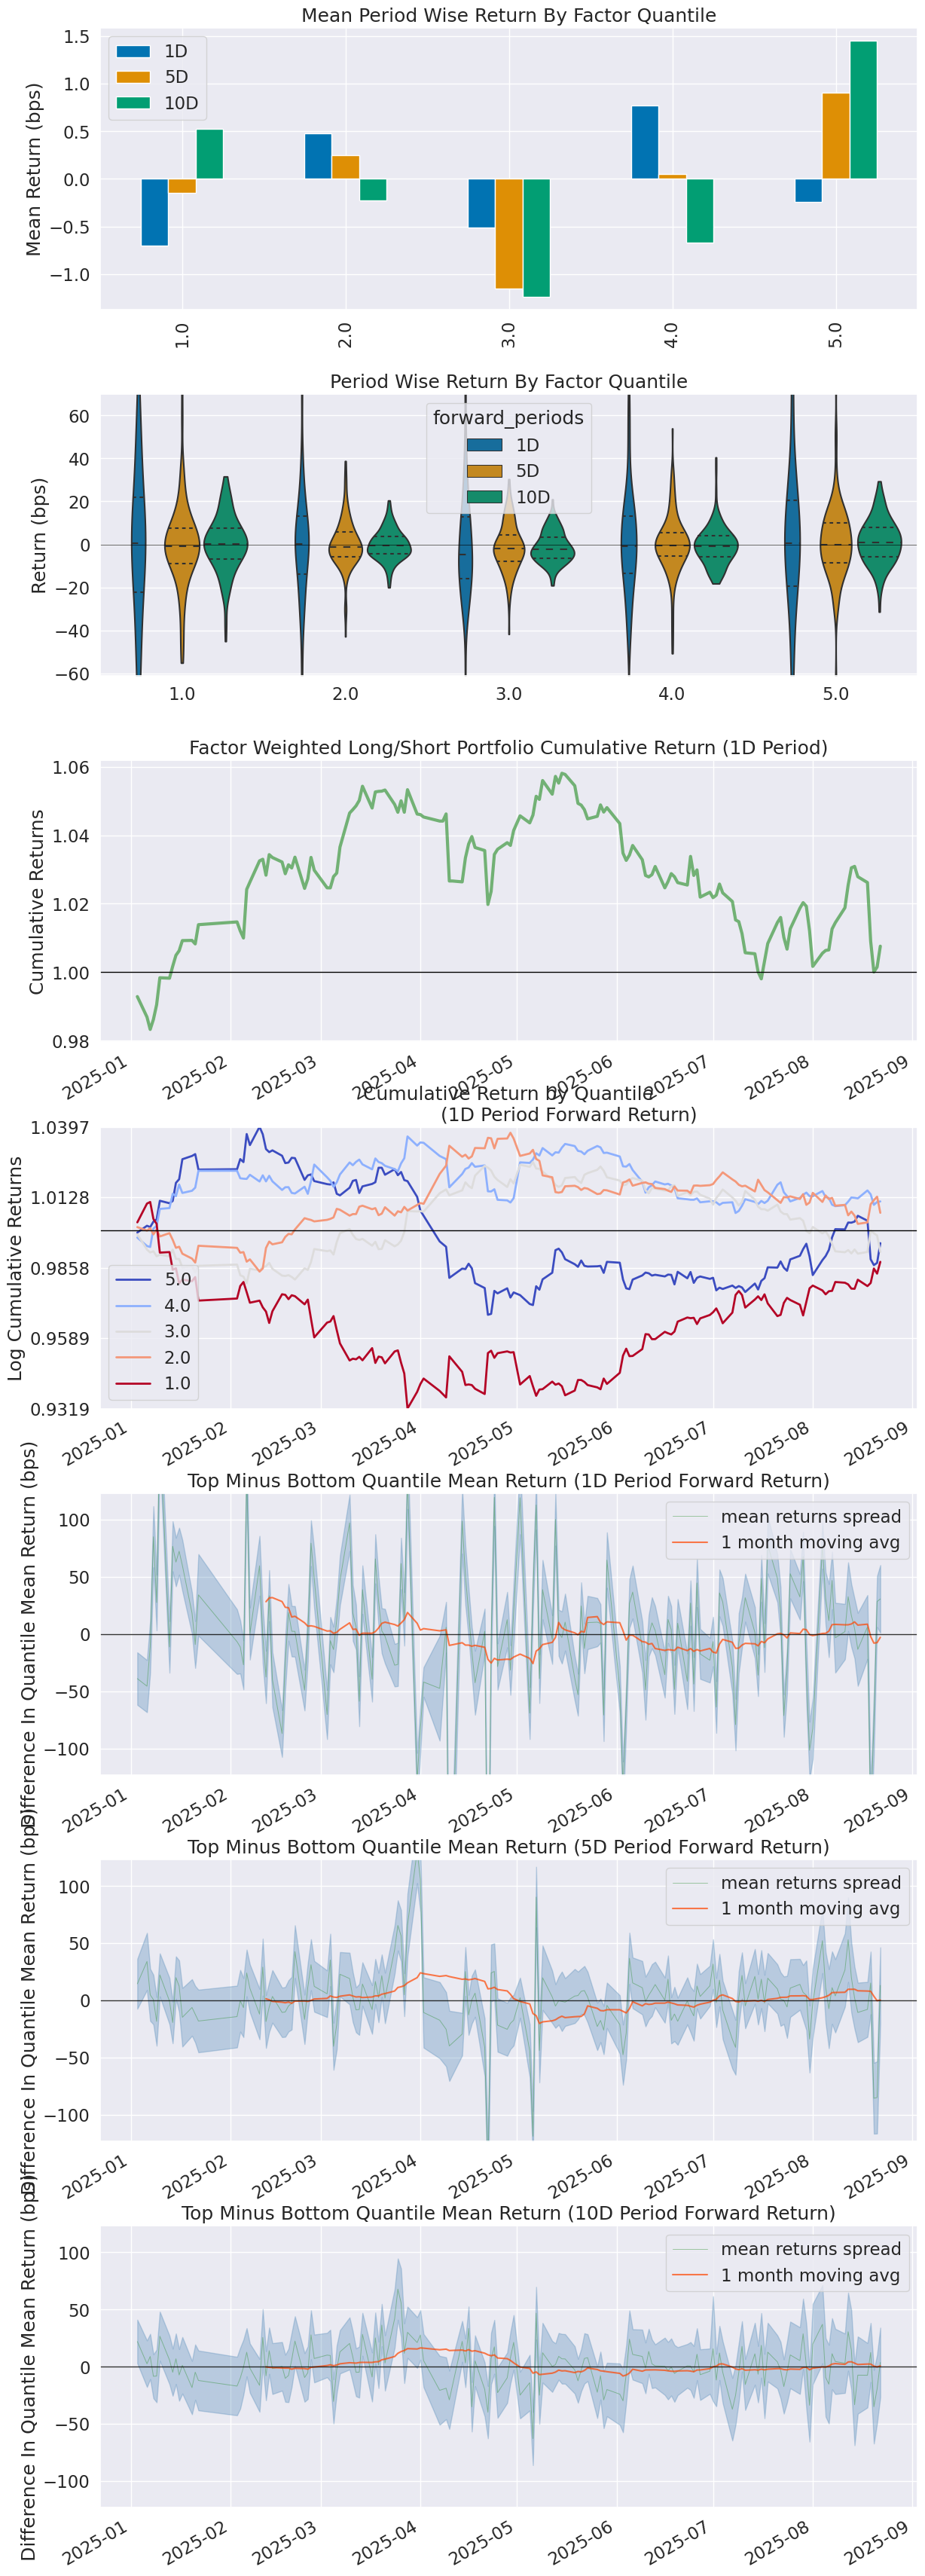

Information Analysis


,1D,5D,10D
IC Mean,0.000,0.003,-0.001
IC Std.,0.117,0.125,0.111
Risk-Adjusted IC,0.003,0.022,-0.008
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/echiu/.local/lib/python3.10/site-packages/alphalens/performance.py:118: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouper.append(pd.Grouper(freq=b

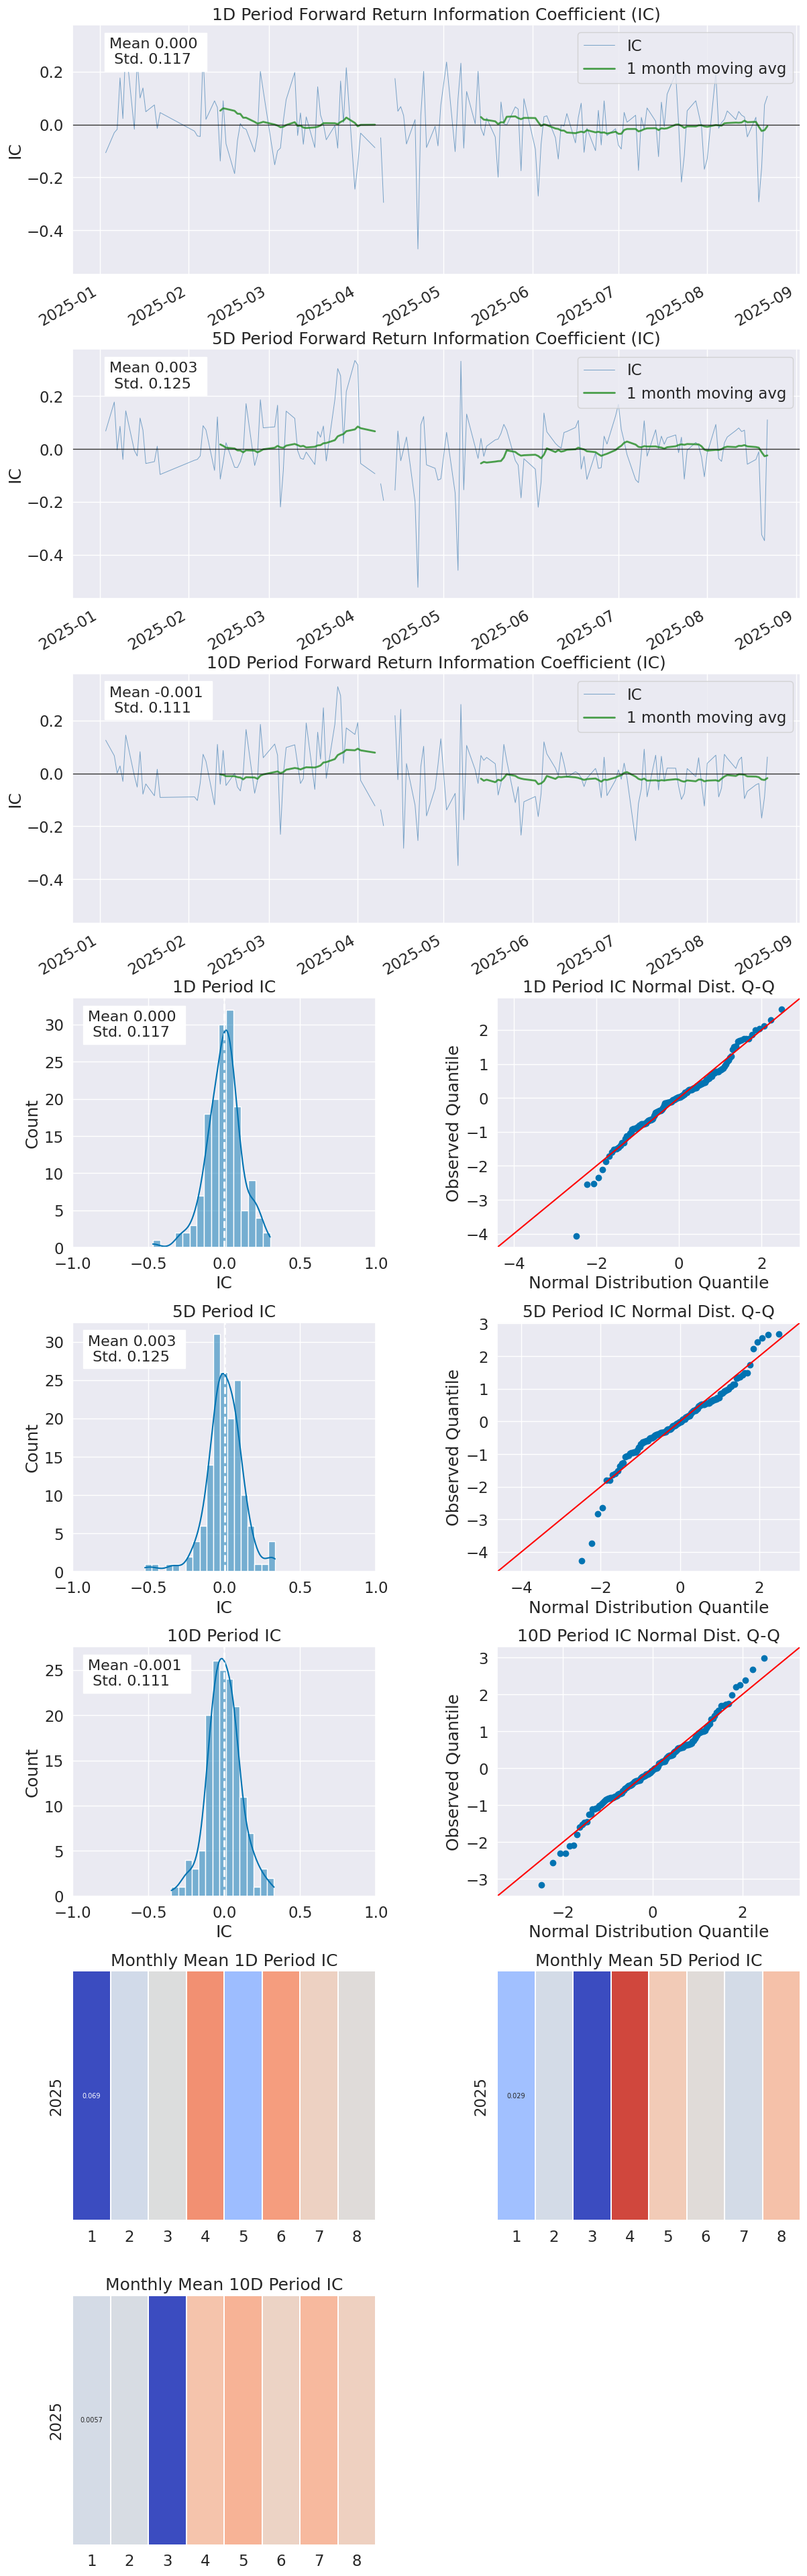

/home/echiu/.local/lib/python3.10/site-packages/alphalens/utils.py:928: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.653,0.648,0.656
Quantile 2.0 Mean Turnover,0.759,0.754,0.751
Quantile 3.0 Mean Turnover,0.712,0.711,0.712
Quantile 4.0 Mean Turnover,0.769,0.762,0.765
Quantile 5.0 Mean Turnover,0.734,0.732,0.730


,1D,5D,10D
Mean Factor Rank Autocorrelation,-0.002,0.022,0.018


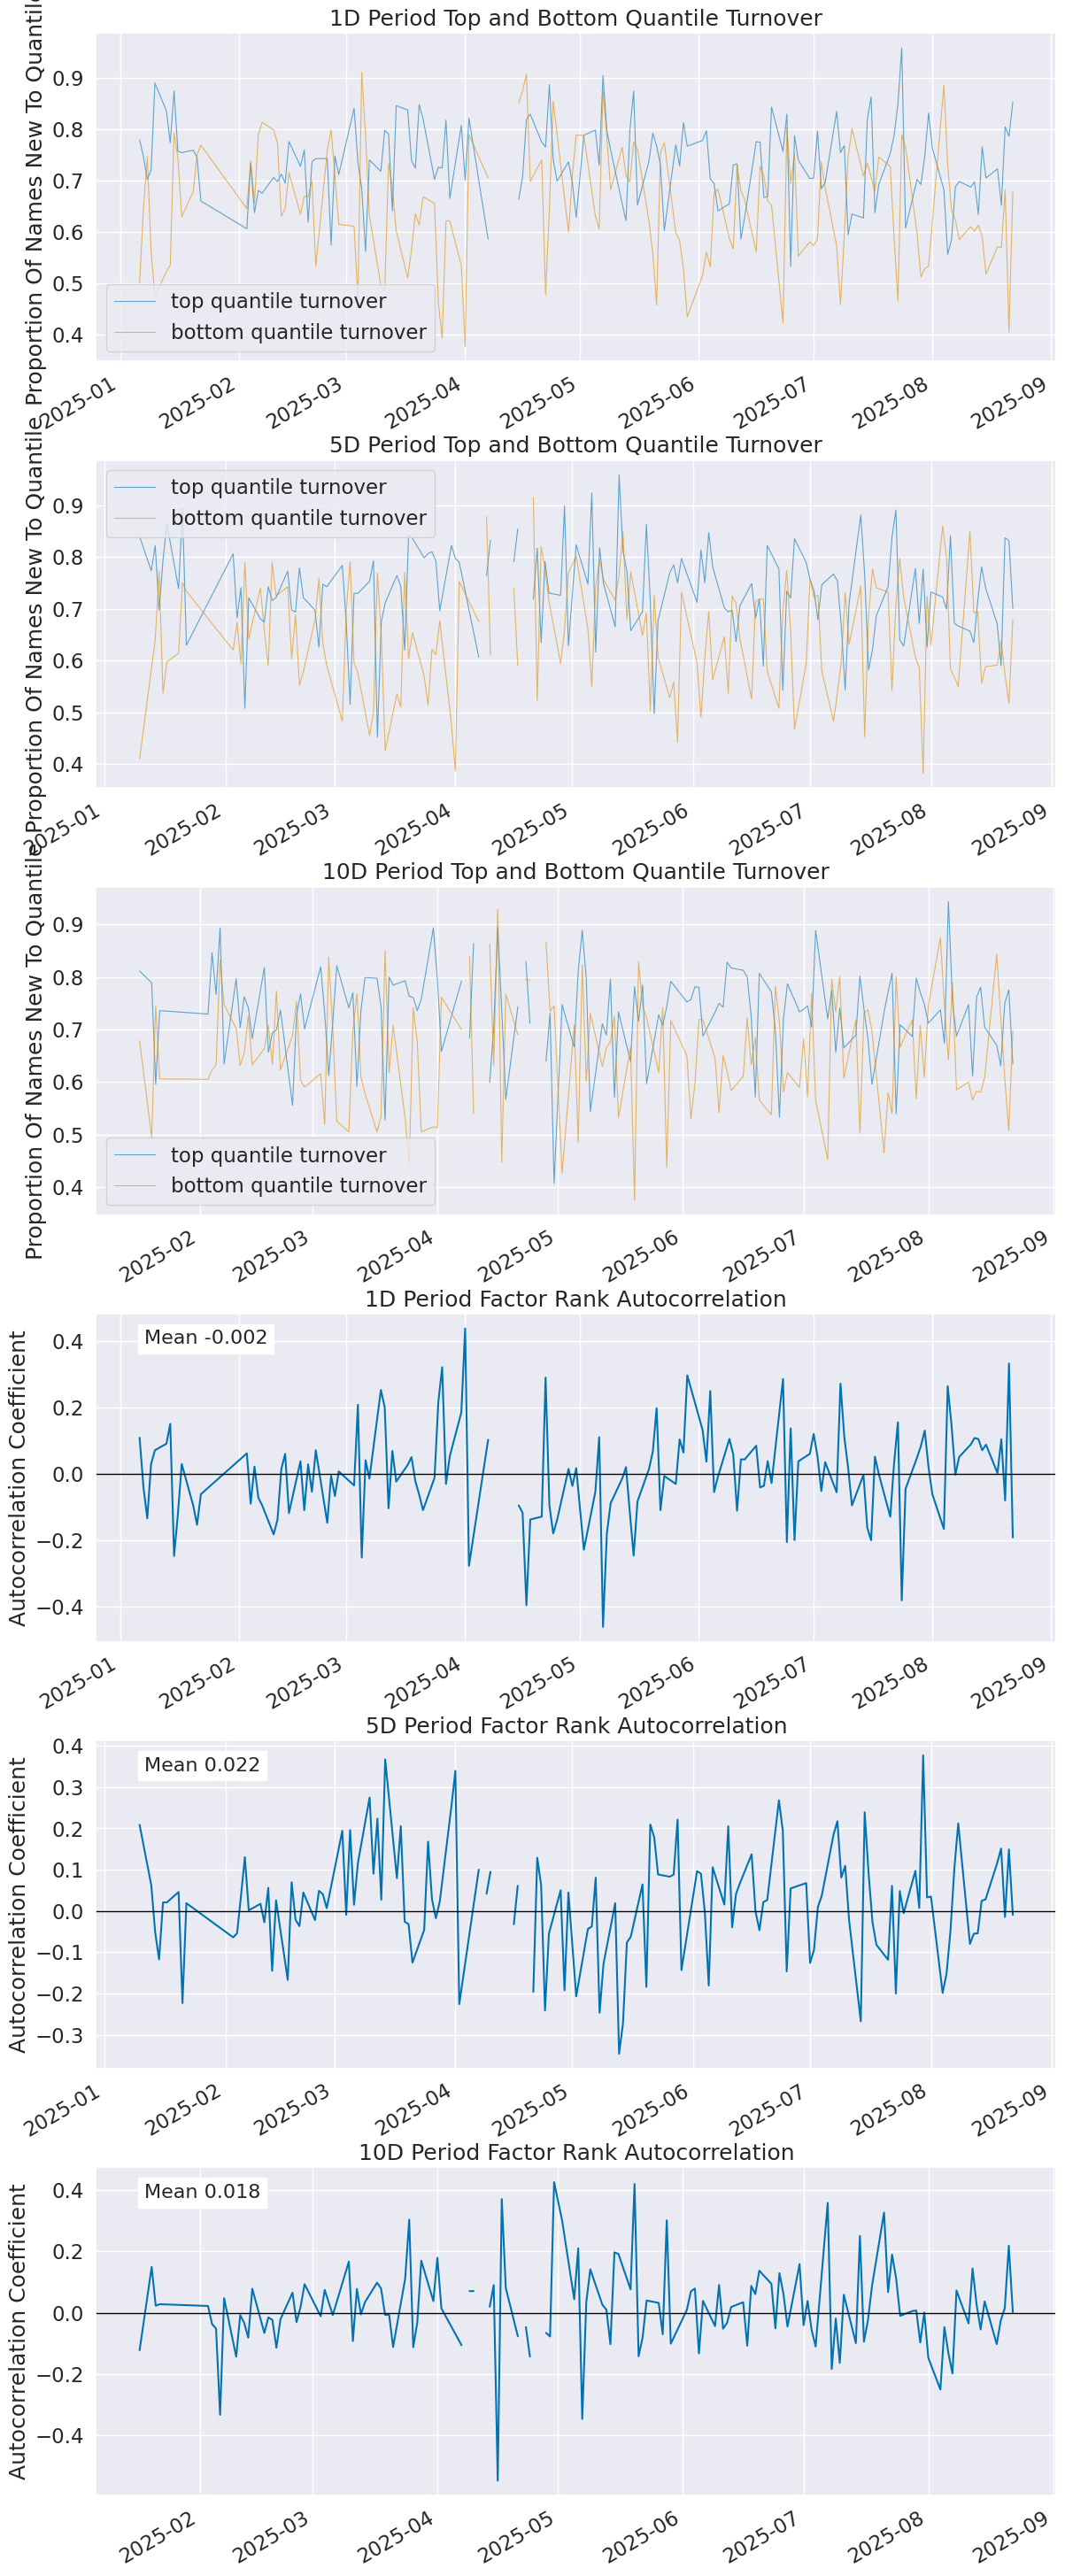

In [12]:
import alphalens as al

# 1. 將資料整理成 alphalens 能用的格式
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor,
    prices,
    periods=[1, 5, 10],  # 未來1天、5天、10天報酬
)

# 2. 產出完整報表
al.tears.create_full_tear_sheet(factor_data)
